# 기계학습 (1005) 5주차

김보람  
2022-10-05

## imports

In [ ]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

### 시각화를 위한 준비함수들

**준비1** loss_fn을 plot하는 함수

In [ ]:
def plot_loss(loss_fn,ax=None):
    if ax==None:
        fig = plt.figure()
        ax=fig.add_subplot(1,1,1,projection='3d')
        ax.elev=15;ax.azim=75
    w0hat,w1hat =torch.meshgrid(torch.arange(-10,3,0.15),torch.arange(-1,10,0.15),indexing='ij')
    w0hat = w0hat.reshape(-1)
    w1hat = w1hat.reshape(-1)
    def l(w0hat,w1hat):
        yhat = torch.exp(w0hat+w1hat*x)/(1+torch.exp(w0hat+w1hat*x))
        return loss_fn(yhat,y) 
    loss = list(map(l,w0hat,w1hat))
    ax.scatter(w0hat,w1hat,loss,s=0.1,alpha=0.2) 
    ax.scatter(-1,5,l(-1,5),s=200,marker='*') # 실제로 -1,5에서 최소값을 가지는건 아님.. 

-   \$y_i Ber(\_i),\$ where
    $\pi_i = \frac{\exp(-1+5x_i)}{1+\exp(-1+5x_i)}$ 에서 생성된 데이터
    한정하여 손실함수가 그려지게 되어있음.

**준비2: for문 대신 돌려주고 epoch마다 필요한 정보를 기록하는 함수**

In [ ]:
def learn_and_record(net, loss_fn, optimizr):
    yhat_history = [] 
    loss_history = []
    what_history = [] 

    for epoc in range(1000): 
        ## step1 
        yhat = net(x)
        ## step2 
        loss = loss_fn(yhat,y)
        ## step3
        loss.backward() 
        ## step4 
        optimizr.step()
        optimizr.zero_grad() 

        ## record 
        if epoc % 20 ==0: 
            yhat_history.append(yhat.reshape(-1).data.tolist())
            loss_history.append(loss.item())
            what_history.append([net[0].bias.data.item(), net[0].weight.data.item()])
    return yhat_history, loss_history, what_history

-   20에폭마다 yhat, loss, what을 기록

**준비3: 애니메이션을 만들어주는 함수**

In [ ]:
from matplotlib import animation
plt.rcParams["animation.html"] = "jshtml"

In [ ]:
def show_lrpr2(net,loss_fn,optimizr,suptitle=''):
    yhat_history,loss_history,what_history = learn_and_record(net,loss_fn,optimizr)
    
    fig = plt.figure(figsize=(7,2.5))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    ax1.set_xticks([]);ax1.set_yticks([])
    ax2.set_xticks([]);ax2.set_yticks([]);ax2.set_zticks([])
    ax2.elev = 15; ax2.azim = 75

    ## ax1: 왼쪽그림 
    ax1.plot(x,v,'--')
    ax1.scatter(x,y,alpha=0.05)
    line, = ax1.plot(x,yhat_history[0],'--') 
    plot_loss(loss_fn,ax2)
    fig.suptitle(suptitle)
    fig.tight_layout()

    def animate(epoc):
        line.set_ydata(yhat_history[epoc])
        ax2.scatter(np.array(what_history)[epoc,0],np.array(what_history)[epoc,1],loss_history[epoc],color='grey')
        return line

    ani = animation.FuncAnimation(fig, animate, frames=30)
    plt.close()
    return ani

-   준비1에서 그려진 loss 함수위에, 준비2의 정보를 조합하여 애니메이션을
    만들어주는 함수

## Logistic intro (review + $\alpha$)

`-` 모델: $x$가 커질수록 $y=1$이 잘나오는 모형은 아래와 같이 설계할 수
있음 \<— 외우세요!!!

-   \$y_i Ber(\_i),\$ where
    $\pi_i = \frac{\exp(w_0+w_1x_i)}{1+\exp(w_0+w_1x_i)}$

-   $\hat{y}_i= \frac{\exp(\hat{w}_0+\hat{w}_1x_i)}{1+\exp(\hat{w}_0+\hat{w}_1x_i)}=\frac{1}{1+\exp(-\hat{w}_0-\hat{w}_1x_i)}$

-   $loss= - \sum_{i=1}^{n} \big(y_i\log(\hat{y}_i)+(1-y_i)\log(1-\hat{y}_i)\big)$
    \<— 외우세요!!

`-` toy example

In [ ]:
x=torch.linspace(-1,1,2000).reshape(2000,1)
w0= -1 
w1= 5 
u = w0+x*w1 
v = torch.exp(u)/(1+torch.exp(u)) # v=πi, 즉 확률을 의미함
y = torch.bernoulli(v) 

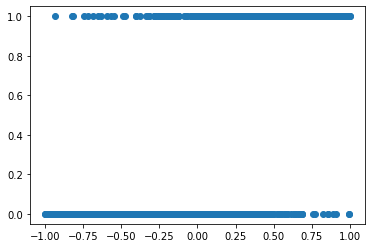

In [ ]:
plt.plot(x,y,'o')

-   note: $(w_0,w_1)$의 true는 $(-1,5)$이다. -\>
    $(\hat{w}_0, \hat{w}_1)$을 적당히 $(-1,5)$근처로 추정하면 된다는
    의미

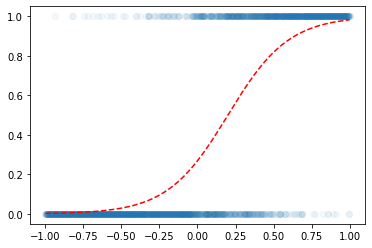

In [ ]:
plt.scatter(x,y,alpha=0.05)
plt.plot(x,v,'--r')

`-` step1: yhat을 만들기

(방법1)

In [ ]:
torch.manual_seed(43052)
l1 = torch.nn.Linear(1,1)  #x의 shape보면(2000,1)인데 뒤에 1이 중요..
a1 = torch.nn.Sigmoid() 
yhat = a1(l1(x))
yhat

(방법2)

In [ ]:
torch.manual_seed(43052)
l1 = torch.nn.Linear(1,1)
a1 = torch.nn.Sigmoid() 
net = torch.nn.Sequential(l1,a1) #net는 l1과 a1의 합성함수
yhat = net(x)
yhat

(방법3)

In [ ]:
torch.manual_seed(43052)
net = torch.nn.Sequential(
    torch.nn.Linear(1,1),
    torch.nn.Sigmoid()
)
yhat = net(x)
yhat

# 단점: a1과 l1 각 통과하는게 궁금한데 이건 중간과정 보기가힘들다.
# len(net) = 2 : 2가 나오네.. 우너소에 접근을 해보자
#net[0], net[1]

In [ ]:
net[0]

In [ ]:
net[0](x)

In [ ]:
net[1] #a1의 기능

In [ ]:
net[1](net[0](x))

`-` step2: loss (일단 MSE로..)

(방법1)

In [ ]:
torch.mean((y-yhat)**2) #mse는 교수님들이 싫어한데.. 왜? 몰라 일단 걍 해보쟈

In [ ]:
loss=torch.mean((y-yhat)**2)
loss

(방법2)

In [ ]:
loss_fn = torch.nn.MSELoss()
loss_fn(yhat,y) # yhat을 먼저쓰자!


`-` step3~4는 동일

`-` 반복 (준비+for문)

In [ ]:
torch.manual_seed(43052)
net = torch.nn.Sequential(
    torch.nn.Linear(in_features=1,out_features=1,bias=True),
    torch.nn.Sigmoid()
)
loss_fn = torch.nn.MSELoss() #MSELoss로 하면.. .. 별로? BCE이거로바꾸기
optimizr = torch.optim.SGD(net.parameters(),lr=0.01)

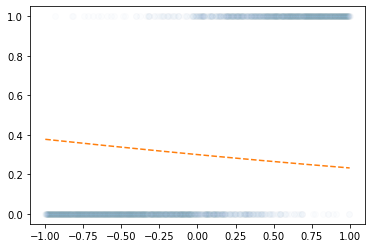

In [ ]:
plt.plot(x,y,'o',alpha=0.01)

plt.plot(x,net(x).data,'--')

In [ ]:
for epoc in range(3000):
    ## step1 
    yhat = net(x) 
    ## step2 
    loss = loss_fn(yhat,y)
    ## step3 
    loss.backward()
    ## step4 
    optimizr.step()
    optimizr.zero_grad() #청소

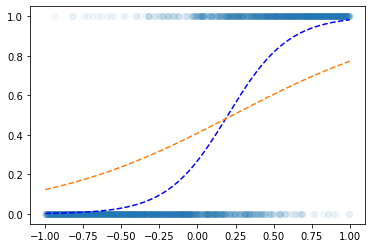

In [ ]:
plt.plot(x,y,'o',alpha=0.05)
plt.plot(x,v,'--b')
plt.plot(x,net(x).data,'--')

## 로지스틱–BCEloss

`-` BCEloss로 바꾸어서 적합하여 보자.

In [ ]:
net = torch.nn.Sequential(
    torch.nn.Linear(in_features=1,out_features=1,bias=True),
    torch.nn.Sigmoid()
)
loss_fn = torch.nn.BCELoss()
optimizr = torch.optim.SGD(net.parameters(),lr=0.01)

In [ ]:
for epoc in range(3000):
    ## step1 
    yhat = net(x) 
    ## step2 
    loss = -torch.mean(y*torch.log(yhat) + (1-y)*torch.log(1-yhat)) # loss_fn(yhat,y)
    ## step3 
    loss.backward()
    ## step4 
    optimizr.step()
    optimizr.zero_grad()

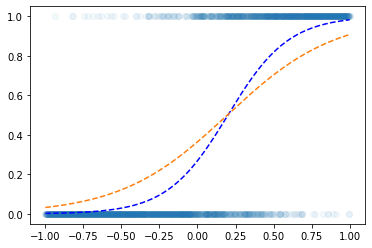

In [ ]:
plt.plot(x,y,'o',alpha=0.05)
plt.plot(x,v,'--b')
plt.plot(x,net(x).data,'--')

`-` 왜 잘맞지? -\> “linear -\> sigmoid” 와 같은 net에 BCEloss를 이용하면
손실함수의 모양이 convex 하기 때문에

In [ ]:
#convex:볼록한... convex가 학습하기 좋은!!

-   plot_loss 함수소개 = 이 예제에 한정하여
    $\hat{w}_0,\hat{w}_1,loss(\hat{w}_0,\hat{w}_1)$를 각각 $x,y,z$ 축에
    그려줍니다.

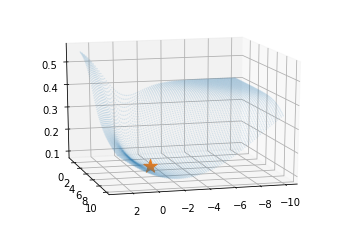

In [ ]:
plot_loss(torch.nn.MSELoss())

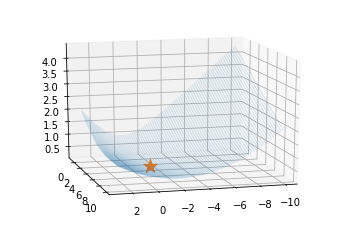

In [ ]:
plot_loss(torch.nn.BCELoss())

### 시각화1: MSE, 좋은초기값

In [ ]:
net = torch.nn.Sequential(
    torch.nn.Linear(1,1),
    torch.nn.Sigmoid()
) 
loss_fn = torch.nn.MSELoss() 
optimizr = torch.optim.SGD(net.parameters(),lr=0.05) #학습률

In [ ]:
l1,a1 = net #초기값 세팅
l1.bias.data = torch.tensor([-3.0]) #세팅값
l1.weight.data = torch.tensor([[-1.0]]) #세팅값

In [ ]:
show_lrpr2(net,loss_fn,optimizr,'MSEloss, good_init // SGD')

### 시각화2: MSE, 나쁜초기값

In [ ]:
net = torch.nn.Sequential(
    torch.nn.Linear(1,1),
    torch.nn.Sigmoid()
) 
loss_fn = torch.nn.MSELoss() 
optimizr = torch.optim.SGD(net.parameters(),lr=0.05) 

In [ ]:
l1,a1 = net
l1.bias.data = torch.tensor([-10.0])
l1.weight.data = torch.tensor([[-1.0]])

In [ ]:
show_lrpr2(net,loss_fn,optimizr,'MSEloss, bad_init // SGD')

### 시각화3: BCE, 좋은초기값

In [ ]:
net = torch.nn.Sequential(
    torch.nn.Linear(1,1),
    torch.nn.Sigmoid()
) 
loss_fn = torch.nn.BCELoss() 
optimizr = torch.optim.SGD(net.parameters(),lr=0.05) 

In [ ]:
l1,a1 = net
l1.bias.data = torch.tensor([-3.0])
l1.weight.data = torch.tensor([[-1.0]])

In [ ]:
show_lrpr2(net,loss_fn,optimizr,'BCEloss, good_init // SGD')

### 시각화4: BCE, 나쁜초기값

In [ ]:
net = torch.nn.Sequential(
    torch.nn.Linear(1,1),
    torch.nn.Sigmoid()
) 
loss_fn = torch.nn.BCELoss() 
optimizr = torch.optim.SGD(net.parameters(),lr=0.05) 

In [ ]:
l1,a1 = net
l1.bias.data = torch.tensor([-3.0])
l1.weight.data = torch.tensor([[-1.0]])

In [ ]:
show_lrpr2(net,loss_fn,optimizr,'BCEloss, good_init // SGD')

## 로지스틱–Adam (국민옵티마이저)

In [ ]:
# Adam은 SGD에 비하여 2가지 면에서 개선점이 있음
# 1. 어려워서 몰라도 뎀
# 2. 가속도의 개념

### 시각화1: MSE, 좋은초기값 –\> 이걸 아담으로!

In [ ]:
net = torch.nn.Sequential(
    torch.nn.Linear(1,1),
    torch.nn.Sigmoid()
) 
loss_fn = torch.nn.MSELoss() 
optimizr = torch.optim.Adam(net.parameters(),lr=0.05)  ## <-- 여기를 수정!

In [ ]:
l1,a1 = net
l1.bias.data = torch.tensor([-3.0])
l1.weight.data = torch.tensor([[-1.0]])

In [ ]:
show_lrpr2(net,loss_fn,optimizr,'MSEloss, good_init // Adam')

### 시각화2: MSE, 나쁜초기값 –\> 이걸 아담으로!

In [ ]:
net = torch.nn.Sequential(
    torch.nn.Linear(1,1),
    torch.nn.Sigmoid()
) 
loss_fn = torch.nn.MSELoss() 
optimizr = torch.optim.Adam(net.parameters(),lr=0.05) 

In [ ]:
l1,a1 = net
l1.bias.data = torch.tensor([-10.0])
l1.weight.data = torch.tensor([[-1.0]])

In [ ]:
show_lrpr2(net,loss_fn,optimizr,'MSEloss, bad_init // Adam')

### 시각화3: BCE, 좋은초기값 –\> 이걸 아담으로! (혼자해봐요..)

In [ ]:
net = torch.nn.Sequential(
    torch.nn.Linear(1,1),
    torch.nn.Sigmoid()
) 
loss_fn = torch.nn.BCELoss() 
optimizr = torch.optim.Adam(net.parameters(),lr=0.05) 

In [ ]:
l1,a1 = net
l1.bias.data = torch.tensor([-3.0])
l1.weight.data = torch.tensor([[-1.0]])

In [ ]:
show_lrpr2(net,loss_fn,optimizr,'BCEloss, good_init // Adam')

### 시각화4: BCE, 나쁜초기값 –\> 이걸 아담으로! (혼자해봐요..)

(참고) Adam이 우수한 이유? SGD보다 두 가지 측면에서 개선이 있었음. 1.
그런게 있음.. 2. 가속도의 개념을 적용!!

## 깊은신경망–로지스틱 회귀의 한계

### 신문기사 (데이터의 모티브)

`-` [스펙이 높아도 취업이 안된다고
합니다..](https://www.joongang.co.kr/article/23637092#home)

**중소·지방 기업 “뽑아봤자 그만두니까”**

중소기업 관계자들은 고스펙 지원자를 꺼리는 이유로 높은 퇴직률을 꼽는다.
여건이 좋은 대기업으로 이직하거나 회사를 관두는 경우가 많다는
하소연이다. 고용정보원이 지난 3일 공개한 자료에 따르면 중소기업
청년취업자 가운데 49.5%가 2년 내에 회사를 그만두는 것으로 나타났다.

중소 IT업체 관계자는 “기업 입장에서 가장 뼈아픈 게 신입사원이 그만둬서
새로 뽑는 일”이라며 “명문대 나온 스펙 좋은 지원자를 뽑아놔도 1년을
채우지 않고 그만두는 사원이 대부분이라 우리도 눈을 낮춰 사람을 뽑는다”고
말했다.

### 가짜데이터

`-` 위의 기사를 모티브로 한 데이터

In [ ]:
df=pd.read_csv('https://raw.githubusercontent.com/guebin/DL2022/master/_notebooks/2022-10-04-dnnex0.csv')
df

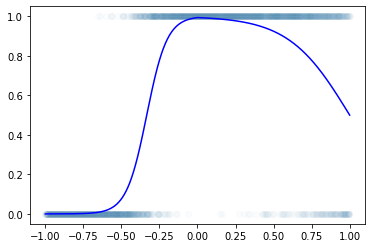

In [ ]:
plt.plot(df.x,df.y,'o',alpha=0.02)
plt.plot(df.x,df.underlying,'-b')

### 로지스틱 회귀로 적합

In [ ]:
#nn: netral network?의 약자

In [ ]:
x= torch.tensor(df.x).float().reshape(-1,1)   #float(): 뒤에 거슬리는거 빼주기
y= torch.tensor(df.y).float().reshape(-1,1)

In [ ]:
torch.manual_seed(43052)
net = torch.nn.Sequential(
    torch.nn.Linear(1,1),
    torch.nn.Sigmoid()
)
yhat=net(x)

In [ ]:
loss_fn = torch.nn.BCELoss() 
loss = loss_fn(yhat,y) # loss = -torch.mean((y)*torch.log(yhat)+(1-y)*torch.log(1-yhat))
loss

In [ ]:
optimizr = torch.optim.Adam(net.parameters()) 

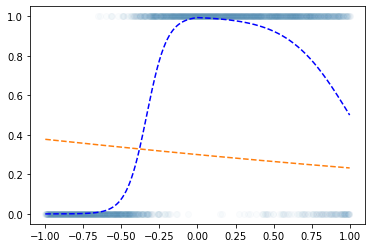

In [ ]:
plt.plot(x,y,'o',alpha=0.02)
plt.plot(df.x,df.underlying,'--b')
plt.plot(x,net(x).data,'--') # 학습전

In [ ]:
for epoc in range(6000):
    ## 1 
    yhat = net(x) 
    ## 2 
    loss = loss_fn(yhat,y) 
    ## 3
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad() 

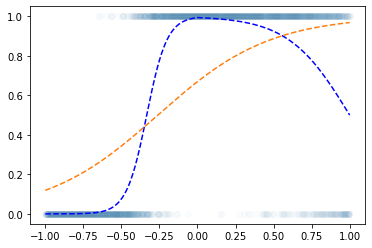

In [ ]:
plt.plot(x,y,'o',alpha=0.02)
plt.plot(df.x,df.underlying,'--b')
plt.plot(x,net(x).data,'--')

`-` 이건 `epoc=6억번`으로 설정해도 못 맞출 것 같다 (증가하다가 감소하는
underlying을 설계하는 것이 불가능) $\to$ 모형의 표현력이 너무 낮다.

### 해결책

`-` sigmoid 넣기 전의 상태가 꺽인 그래프 이어야 한다.

In [ ]:
sig = torch.nn.Sigmoid()

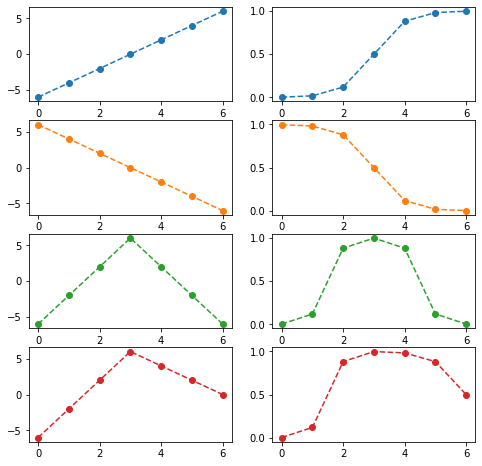

In [ ]:
fig,ax = plt.subplots(4,2,figsize=(8,8))
u1 = torch.tensor([-6,-4,-2,0,2,4,6])
u2 = torch.tensor([6,4,2,0,-2,-4,-6])
u3 = torch.tensor([-6,-2,2,6,2,-2,-6])
u4 = torch.tensor([-6,-2,2,6,4,2,0])
ax[0,0].plot(u1,'--o',color='C0');ax[0,1].plot(sig(u1),'--o',color='C0')
ax[1,0].plot(u2,'--o',color='C1');ax[1,1].plot(sig(u2),'--o',color='C1')
ax[2,0].plot(u3,'--o',color='C2');ax[2,1].plot(sig(u3),'--o',color='C2')
ax[3,0].plot(u4,'--o',color='C3');ax[3,1].plot(sig(u4),'--o',color='C3')

## 깊은신경망–DNN을 이용한 해결

`-` 목표: 아래와 같은 벡터 ${\boldsymbol u}$를 만들어보자.

${\boldsymbol u} = [u_1,u_2,\dots,u_{2000}], \quad u_i = \begin{cases} 9x_i +4.5& x_i <0 \\ -4.5x_i + 4.5& x_i >0 \end{cases}$

### 꺽인 그래프를 만드는 방법1

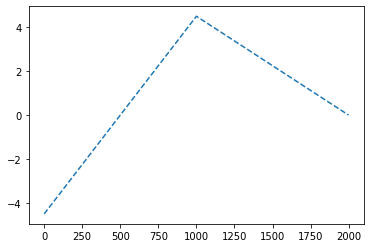

In [ ]:
u = [9*xi+4.5 if xi <0 else -4.5*xi+4.5 for xi in x.reshape(-1).tolist()]  #tolist하면 list화 
plt.plot(u,'--')

### 꺽인 그래프를 만드는 방법2

`-` 전략: 선형변환 $\to$ ReLU $\to$ 선형변환

(예비학습) ReLU 함수란?

$ReLU(x) = \max(0,x)$

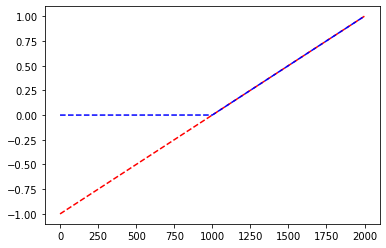

In [ ]:
relu=torch.nn.ReLU()
plt.plot(x,'--r')
plt.plot(relu(x),'--b')

-   빨간색: `x`, 파란색: `relu(x)`

예비학습끝

우리 전략 다시 확인: 선형변환1 -\> 렐루 -\> 선형변환2

***(선형변환1)***

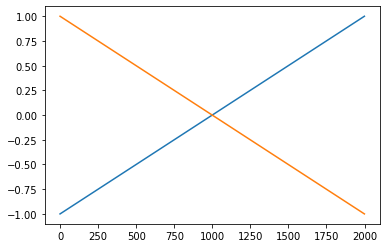

In [ ]:
plt.plot(x);plt.plot(-x)

***(렐루)***

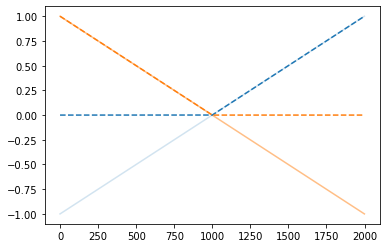

In [ ]:
plt.plot(x,alpha=0.2);plt.plot(-x,alpha=0.5)
plt.plot(relu(x),'--',color='C0');plt.plot(relu(-x),'--',color='C1')

#out feature을 2로 잡는당->선을 두개로

***(선형변환2)***

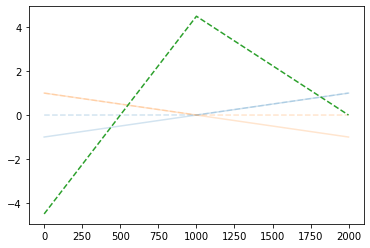

In [ ]:
plt.plot(x,alpha=0.2);plt.plot(-x,alpha=0.2)
plt.plot(relu(x),'--',color='C0',alpha=0.2);plt.plot(relu(-x),'--',color='C1',alpha=0.2)
plt.plot(-4.5*relu(x)-9.0*relu(-x)+4.5,'--',color='C2')

#하늘색 점선과 노란색 점섬을 더해보자..

이제 초록색선에 sig를 취하기만 하면?

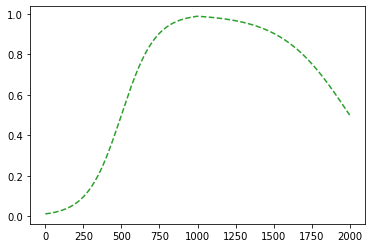

In [ ]:
plt.plot(sig(-4.5*relu(x)-9.0*relu(-x)+4.5),'--',color='C2')

정리하면!

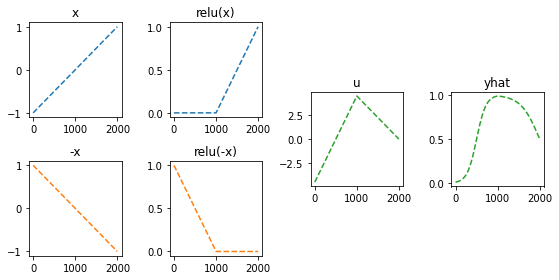

In [ ]:
fig = plt.figure(figsize=(8, 4))
spec = fig.add_gridspec(4, 4)
ax1 = fig.add_subplot(spec[:2,0]); ax1.set_title('x'); ax1.plot(x,'--',color='C0')
ax2 = fig.add_subplot(spec[2:,0]); ax2.set_title('-x'); ax2.plot(-x,'--',color='C1')
ax3 = fig.add_subplot(spec[:2,1]); ax3.set_title('relu(x)'); ax3.plot(relu(x),'--',color='C0')
ax4 = fig.add_subplot(spec[2:,1]); ax4.set_title('relu(-x)'); ax4.plot(relu(-x),'--',color='C1')
ax5 = fig.add_subplot(spec[1:3,2]); ax5.set_title('u'); ax5.plot(-4.5*relu(x)-9*relu(-x)+4.5,'--',color='C2')
ax6 = fig.add_subplot(spec[1:3,3]); ax6.set_title('yhat'); ax6.plot(sig(-4.5*relu(x)-9*relu(-x)+4.5),'--',color='C2')
fig.tight_layout()

-   이런느낌으로 $\hat{\boldsymbol y}$을 만들면 된다.

### torch.nn.Linear()를 이용한 꺽인 그래프 구현

In [ ]:
torch.manual_seed(43052)
l1 = torch.nn.Linear(in_features=1,out_features=2,bias=True) 
a1 = torch.nn.ReLU()
l2 = torch.nn.Linear(in_features=2,out_features=1,bias=True) 
a2 = torch.nn.Sigmoid() 

In [ ]:
net = torch.nn.Sequential(l1,a1,l2,a2) 

In [ ]:
l1.weight,l1.bias,l2.weight,l2.bias

In [ ]:
l1.weight.data = torch.tensor([[1.0],[-1.0]])
l1.bias.data = torch.tensor([0.0, 0.0])
l2.weight.data = torch.tensor([[ -4.5, -9.0]])
l2.bias.data= torch.tensor([4.5])
l1.weight,l1.bias,l2.weight,l2.bias

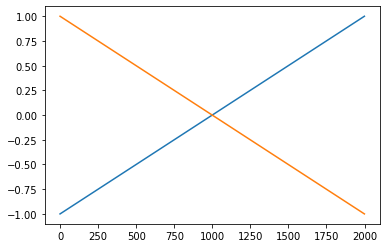

In [ ]:
plt.plot(l1(x).data)

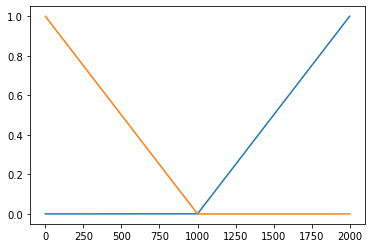

In [ ]:
plt.plot(a1(l1(x)).data)

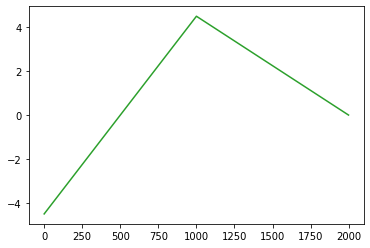

In [ ]:
plt.plot(l2(a1(l1(x))).data,color='C2')

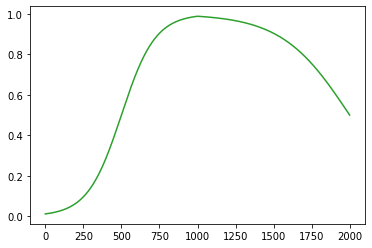

In [ ]:
plt.plot(a2(l2(a1(l1(x)))).data,color='C2')
#plt.plot(net(x).data,color='C2')

`-` 수식표현

1.  ${\bf X}=\begin{bmatrix} x_1 \\ \dots \\ x_n \end{bmatrix}$

2.  $l_1({\bf X})={\bf X}{\bf W}^{(1)}\overset{bc}{+} {\boldsymbol b}^{(1)}=\begin{bmatrix} x_1 & -x_1 \\ x_2 & -x_2 \\ \dots & \dots \\ x_n & -x_n\end{bmatrix}$

    -   ${\bf W}^{(1)}=\begin{bmatrix} 1 & -1 \end{bmatrix}$
    -   ${\boldsymbol b}^{(1)}=\begin{bmatrix} 0 & 0 \end{bmatrix}$

3.  $(a_1\circ l_1)({\bf X})=\text{relu}\big({\bf X}{\bf W}^{(1)}\overset{bc}{+}{\boldsymbol b}^{(1)}\big)=\begin{bmatrix} \text{relu}(x_1) & \text{relu}(-x_1) \\ \text{relu}(x_2) & \text{relu}(-x_2) \\ \dots & \dots \\ \text{relu}(x_n) & \text{relu}(-x_n)\end{bmatrix}$

4.  $(l_2 \circ a_1\circ l_1)({\bf X})=\text{relu}\big({\bf X}{\bf W}^{(1)}\overset{bc}{+}{\boldsymbol b}^{(1)}\big){\bf W}^{(2)}\overset{bc}{+}b^{(2)}\\ =\begin{bmatrix} -4.5\times\text{relu}(x_1) -9.0 \times \text{relu}(-x_1) +4.5 \\ -4.5\times\text{relu}(x_2) -9.0 \times\text{relu}(-x_2) + 4.5 \\ \dots \\ -4.5\times \text{relu}(x_n) -9.0 \times\text{relu}(-x_n)+4.5 \end{bmatrix}$

    -   ${\bf W}^{(2)}=\begin{bmatrix} -4.5 \\ -9 \end{bmatrix}$
    -   $b^{(2)}=4.5$

5.  $net({\bf X})=(a_2 \circ l_2 \circ a_1\circ l_1)({\bf X})=\text{sig}\Big(\text{relu}\big({\bf X}{\bf W}^{(1)}\overset{bc}{+}{\boldsymbol b}^{(1)}\big){\bf W}^{(2)}\overset{bc}{+}b^{(2)}\Big)\\=\begin{bmatrix} \text{sig}\Big(-4.5\times\text{relu}(x_1) -9.0 \times \text{relu}(-x_1) +4.5\Big) \\ \text{sig}\Big(-4.5\times\text{relu}(x_2) -9.0 \times\text{relu}(-x_2) + 4.5 \Big)\\ \dots \\ \text{sig}\Big(-4.5\times \text{relu}(x_n) -9.0 \times\text{relu}(-x_n)+4.5 \Big)\end{bmatrix}$

`-` 차원만 따지자

$\underset{(n,1)}{\bf X} \overset{l_1}{\to} \underset{(n,2)}{\boldsymbol u^{(1)}} \overset{a_1}{\to} \underset{(n,2)}{\boldsymbol v^{(1)}} \overset{l_2}{\to} \underset{(n,1)}{\boldsymbol u^{(2)}} \overset{a_2}{\to} \underset{(n,1)}{\boldsymbol v^{(2)}}=\underset{(n,1)}{\hat{\boldsymbol y}}$

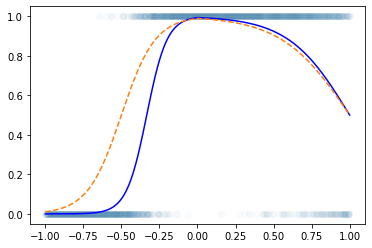

In [ ]:
plt.plot(x,y,'o',alpha=0.02)
plt.plot(x,df.underlying,'-b')
plt.plot(x,net(x).data,'--')

### Step1 ~ Step4

`-` 준비

In [ ]:
torch.manual_seed(43052)
net = torch.nn.Sequential(
    torch.nn.Linear(in_features=1,out_features=2), #u1=l1(x), x:(n,1) --> u1:(n,2) 
    torch.nn.ReLU(), # v1=a1(u1), u1:(n,2) --> v1:(n,2) 
    torch.nn.Linear(in_features=2,out_features=1), # u2=l2(v1), v1:(n,2) --> u2:(n,1) 
    torch.nn.Sigmoid() # v2=a2(u2), u2:(n,1) --> v2:(n,1) 
) 

In [ ]:
loss_fn = torch.nn.BCELoss()

In [ ]:
optimizr = torch.optim.Adam(net.parameters()) # lr은 디폴트값으로..

`-` 반복

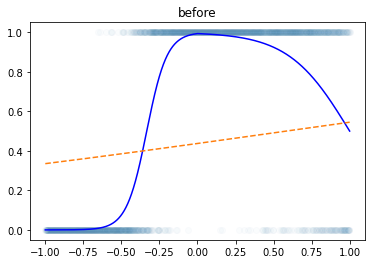

In [ ]:
plt.plot(x,y,'o',alpha=0.02)
plt.plot(x,df.underlying,'-b')
plt.plot(x,net(x).data,'--')
plt.title("before")

In [ ]:
for epoc in range(3000):
    ## step1 
    yhat = net(x) 
    ## step2 
    loss = loss_fn(yhat,y) 
    ## step3
    loss.backward()
    ## step4 
    optimizr.step()
    optimizr.zero_grad()

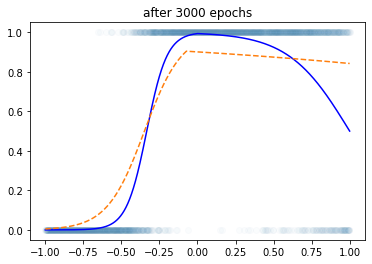

In [ ]:
plt.plot(x,y,'o',alpha=0.02)
plt.plot(x,df.underlying,'-b')
plt.plot(x,net(x).data,'--',color='C1')
plt.title("after 3000 epochs")

In [ ]:
for epoc in range(3000):
    ## step1 
    yhat = net(x) 
    ## step2 
    loss = loss_fn(yhat,y) 
    ## step3
    loss.backward()
    ## step4 
    optimizr.step()
    optimizr.zero_grad()

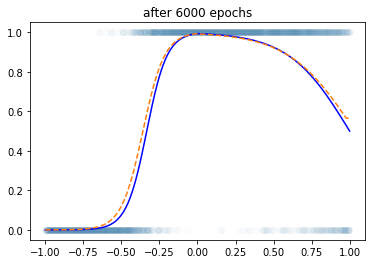

In [ ]:
plt.plot(x,y,'o',alpha=0.02)
plt.plot(x,df.underlying,'-b')
plt.plot(x,net(x).data,'--',color='C1')
plt.title("after 6000 epochs")

## 깊은신경망–DNN으로 해결가능한 다양한 예제

### 예제1

`-` 언뜻 생각하면 방금 배운 기술은 sig를 취하기 전이 꺽은선인 형태만
가능할 듯 하다. $\to$ 그래서 이 역시 표현력이 부족할 듯 하다. $\to$
그런데 생각보다 표현력이 풍부한 편이다. 즉 생각보다 쓸 만하다.

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/guebin/DL2022/master/_notebooks/2022-10-04-dnnex1.csv')

In [ ]:
# 데이터정리
x = torch.tensor(df.x).float().reshape(-1,1)
y = torch.tensor(df.y).float().reshape(-1,1)

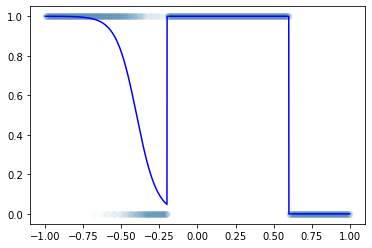

In [ ]:
plt.plot(x,y,'o',alpha=0.02)
plt.plot(df.x,df.underlying,'-b')

-   이거 시그모이드 취하기 직전은 step이 포함된 듯 $\to$ 그래서
    꺽은선으로는 표현할 수 없는 구조임 $\to$ 그런데 사실 대충은 표현가능

In [ ]:
torch.manual_seed(43052)
net = torch.nn.Sequential(
    torch.nn.Linear(in_features=1,out_features=16), # x:(n,1) --> u1:(n,16) #최대 16번 꺾일 수 있음..
    torch.nn.ReLU(), # u1:(n,16) --> v1:(n,16)
    torch.nn.Linear(in_features=16,out_features=1), # v1:(n,16) --> u2:(n,1) 
    torch.nn.Sigmoid() # u2:(n,1) --> v2:(n,1) 
)

-   $\underset{(n,1)}{\bf X} \overset{l_1}{\to} \underset{(n,16)}{\boldsymbol u^{(1)}} \overset{a_1}{\to} \underset{(n,16)}{\boldsymbol v^{(1)}} \overset{l_2}{\to} \underset{(n,1)}{\boldsymbol u^{(2)}} \overset{a_2}{\to} \underset{(n,1)}{\boldsymbol v^{(2)}}=\underset{(n,1)}{\hat{\boldsymbol y}}$

In [ ]:
loss_fn = torch.nn.BCELoss()

In [ ]:
optimizr = torch.optim.Adam(net.parameters())

In [ ]:
for epoc in range(6000):
    ## 1
    yhat = net(x) 
    ## 2 
    loss = loss_fn(yhat,y)
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()    

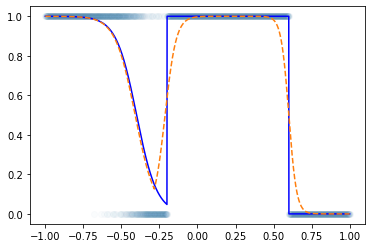

In [ ]:
plt.plot(x,y,'o',alpha=0.02)
plt.plot(df.x,df.underlying,'-b') #실제로는 관츷ㄱ 못하는거
plt.plot(x,net(x).data,'--')

### 예제2

`-` 사실 꺽은선의 조합으로 꽤 많은걸 표현할 수 있거든요? $\to$ 심지어
곡선도 대충 맞게 적합된다.

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/guebin/DL2022/master/_notebooks/2022-10-04-dnnex2.csv')

In [ ]:
x = torch.tensor(df.x).float().reshape(-1,1)
y = torch.tensor(df.y).float().reshape(-1,1)

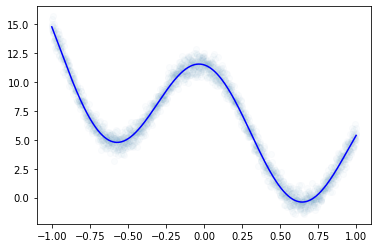

In [ ]:
plt.plot(x,y,'o',alpha=0.02)
plt.plot(df.x,df.underlying,'-b')

In [ ]:
x=torch.tensor(df.x).float().reshape(-1,1)
y=torch.tensor(df.y).float().reshape(-1,1)

(풀이1)

In [ ]:
torch.manual_seed(43052)
net = torch.nn.Sequential(
    torch.nn.Linear(in_features=1,out_features=32), # x:(n,1) --> u1:(n,32)
    torch.nn.ReLU(), # u1:(n,32) --> v1:(n,32) 
    torch.nn.Linear(in_features=32,out_features=1) # v1:(n,32) --> u2:(n,1)
)

-   $\underset{(n,1)}{\bf X} \overset{l_1}{\to} \underset{(n,32)}{\boldsymbol u^{(1)}} \overset{a_1}{\to} \underset{(n,32)}{\boldsymbol v^{(1)}} \overset{l_2}{\to} \underset{(n,1)}{\boldsymbol u^{(2)}}=\underset{(n,1)}{\hat{\boldsymbol y}}$

In [ ]:
loss_fn = torch.nn.MSELoss() #mseloss:마지막에 sigmoid형태가 아니니까!

In [ ]:
optimizr = torch.optim.Adam(net.parameters())

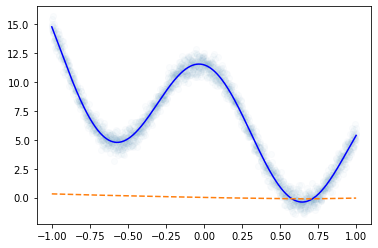

In [ ]:
plt.plot(x,y,'o',alpha=0.02)
plt.plot(df.x,df.underlying,'-b')
plt.plot(x,net(x).data,'--')

In [ ]:
for epoc in range(6000): 
    ## 1 
    yhat = net(x) 
    ## 2 
    loss = loss_fn(yhat,y) 
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

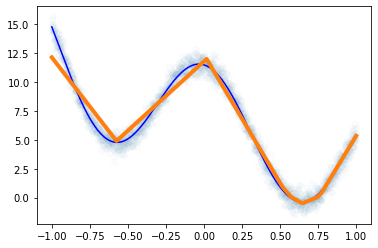

In [ ]:
plt.plot(x,y,'o',alpha=0.02)
plt.plot(df.x,df.underlying,'-b')
plt.plot(x,net(x).data,lw=4) #lw:두겁게

(풀이2) – 풀이1보다 좀 더 잘맞음. 잘 맞는 이유? 좋은초기값 (=운)

In [ ]:
torch.manual_seed(5)  # seed값을 43052->5로바꿔주기...
net = torch.nn.Sequential(
    torch.nn.Linear(in_features=1,out_features=32), # x:(n,1) --> u1:(n,32)
    torch.nn.ReLU(), # u1:(n,32) --> v1:(n,32) 
    torch.nn.Linear(in_features=32,out_features=1) # v1:(n,32) --> u2:(n,1)
)

-   $\underset{(n,1)}{\bf X} \overset{l_1}{\to} \underset{(n,32)}{\boldsymbol u^{(1)}} \overset{a_1}{\to} \underset{(n,32)}{\boldsymbol v^{(1)}} \overset{l_2}{\to} \underset{(n,1)}{\boldsymbol u^{(2)}}=\underset{(n,1)}{\hat{\boldsymbol y}}$

In [ ]:
loss_fn = torch.nn.MSELoss() 

In [ ]:
optimizr = torch.optim.Adam(net.parameters())

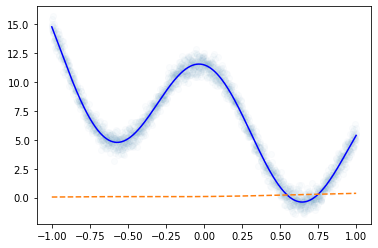

In [ ]:
plt.plot(x,y,'o',alpha=0.02)
plt.plot(df.x,df.underlying,'-b')
plt.plot(x,net(x).data,'--')

In [ ]:
for epoc in range(6000): 
    ## 1 
    yhat = net(x) 
    ## 2 
    loss = loss_fn(yhat,y) 
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

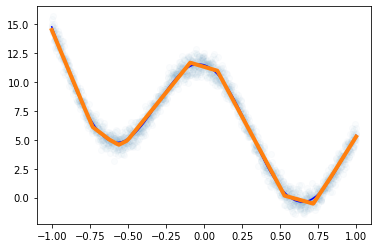

In [ ]:
plt.plot(x,y,'o',alpha=0.02)
plt.plot(df.x,df.underlying,'-b')
plt.plot(x,net(x).data,lw=4)

-   풀이1에서 에폭을 많이 반복하면 풀이2의 적합선이 나올까? –\> 안나옴!!
    (local min에 빠졌다)

### 예제3

In [ ]:
import seaborn as sns

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/guebin/DL2022/master/_notebooks/2022-10-04-dnnex3.csv')
df

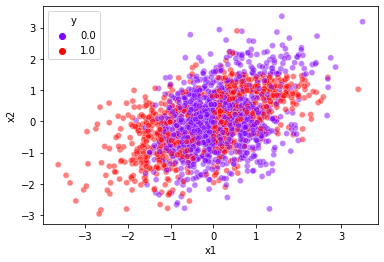

In [ ]:
sns.scatterplot(data=df,x='x1',y='x2',hue='y',alpha=0.5,palette={0:(0.5, 0.0, 1.0),1:(1.0,0.0,0.0)})

In [ ]:
# 데이터준비
x1 = torch.tensor(df.x1).float().reshape(-1,1) 
x2 = torch.tensor(df.x2).float().reshape(-1,1) 
X = torch.concat([x1,x2],axis=1) 
y = torch.tensor(df.y).float().reshape(-1,1) 

In [ ]:
X.shape

In [ ]:
torch.manual_seed(43052)
net = torch.nn.Sequential(
    torch.nn.Linear(in_features=2,out_features=32),#X의 shape이 2니까 in_features=2
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=32,out_features=1),
    torch.nn.Sigmoid()
)

-   $\underset{(n,2)}{\bf X} \overset{l_1}{\to} \underset{(n,32)}{\boldsymbol u^{(1)}} \overset{a_1}{\to} \underset{(n,32)}{\boldsymbol v^{(1)}} \overset{l_2}{\to} \underset{(n,1)}{\boldsymbol u^{(2)}} \overset{a_2}{\to} \underset{(n,1)}{\boldsymbol v^{(2)}}=\underset{(n,1)}{\hat{\boldsymbol y}}$

In [ ]:
loss_fn = torch.nn.BCELoss() 

In [ ]:
optimizr = torch.optim.Adam(net.parameters()) 

In [ ]:
for epoc in range(3000):
    ## 1 
    yhat = net(X) 
    ## 2 
    loss = loss_fn(yhat,y) 
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad() 

In [ ]:
df2 = df.assign(yhat=yhat.reshape(-1).detach().tolist()) #seaborn을 그리려먼 dataframe형식으로 되어잇어야해
df2

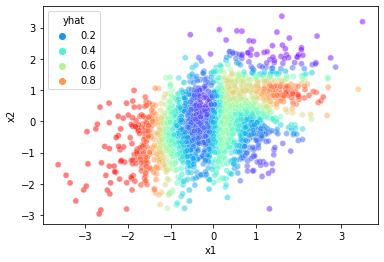

In [ ]:
sns.scatterplot(data=df2,x='x1',y='x2',hue='yhat',alpha=0.5,palette='rainbow')

`-` 결과시각화

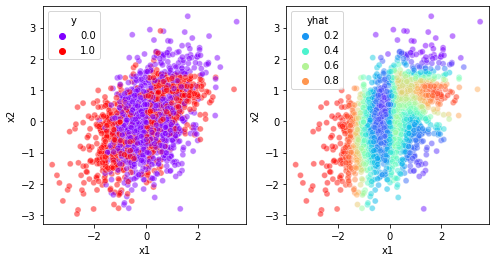

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(8,4))
sns.scatterplot(data=df,x='x1',y='x2',hue='y',alpha=0.5,palette={0:(0.5, 0.0, 1.0),1:(1.0,0.0,0.0)},ax=ax[0])
sns.scatterplot(data=df2,x='x1',y='x2',hue='yhat',alpha=0.5,palette='rainbow',ax=ax[1])

`-` 교훈: underlying이 엄청 이상해보여도 생각보다 잘 맞춤